In [2]:
import nibabel as nib
import numpy as np
import pydicom as pydicom
import os
import sys
import shutil
import SimpleITK as sitk
from glob import glob
import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize

In [21]:
mypath = "/data/Datasets/stroke/clinical_validation"
mypath_output = "dicom2"

mylist3 = ['ACV-234','ACV-259','ACV-127','ACV-241','ACV-287','ACV-249','ACV-294','ACV-254','ACV-253','ACV-242','ACV-238','ACV-265','ACV-233','ACV-263','ACV-225']

In [2]:
def writeSlices(series_tag_values, new_img, i, out_dir, ns):
    #print("GG", i)
    #print("GG", ns)
    image_slice = new_img[:,:,ns-i]
    writer = sitk.ImageFileWriter()
    writer.KeepOriginalImageUIDOn()

    # Tags shared by the series.
    list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0], tag_value[1]), series_tag_values))

    # Slice specific tags.
    image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
    image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time

    # Setting the type to CT preserves the slice location.
    image_slice.SetMetaData("0008|0060", "CT")  # set the type to CT so the thickness is carried over

    # (0020, 0032) image position patient determines the 3D spacing between slices.
    image_slice.SetMetaData("0020|0032", '\\'.join(map(str,new_img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
    image_slice.SetMetaData("0020,0013", str(i)) # Instance Number

    # Write to the output directory and add the extension dcm, to force writing in DICOM format.
    #writer.SetFileName(os.path.join(out_dir,'slice' + str(i).zfill(4) + '.dcm'))
    writer.SetFileName(os.path.join(out_dir, "I"+str(i+1).zfill(5)+".dcm"))
    writer.Execute(image_slice)


def nifti2dicom_1file(in_dir, out_dir):
    """
    This function is to convert only one nifti file into dicom series

    `nifti_dir`: the path to the one nifti file
    `out_dir`: the path to output
    """

    os.makedirs(out_dir, exist_ok=True)

    new_img = sitk.ReadImage(in_dir)
    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    direction = new_img.GetDirection()
    series_tag_values = [("0008|0031",modification_time), # Series Time
                    ("0008|0021",modification_date), # Series Date
                    ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                    ("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time), # Series Instance UID
                    ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                        direction[1],direction[4],direction[7])))),
                    ("0008|103e", "Created-Pycad")] # Series Description

    # Write slices to output directory
    #print("GG", new_img.GetDepth())
    ns = new_img.GetDepth()-1
    list(map(lambda i: writeSlices(series_tag_values, new_img, i, out_dir, ns), range(new_img.GetDepth())))

In [3]:
def nifti2dicom(in_dir, out_dir):
    print("in_dir", in_dir)
    nifti_file = nib.load(in_dir).get_fdata()

    print(nifti_file.shape)
    if nifti_file.shape[0]>256:
        print("Resizing!")
        nifti_file = nifti_file[:,:,:,0,0]
        nifti_file = resize(nifti_file, (256,256))
    elif nifti_file.shape[0]<nifti_file.shape[1]:
        print("Más ancho que alto!")
        nx = (nifti_file.shape[1]-256)//2
        nifti_file = nifti_file[:,nx:nx+256,:,0,0]
    else:
        True
    # fix01 = ["ACV-106"]
    # fix02 = ["ACV-229"]
    # fix03 = ["ACV-229"]
    # fix04 = ["ACV-229","ACV-237","ACV-246","ACV-252","ACV-260","ACV-267","ACV-268","ACV-269","ACV-281","ACV-285","ACV-288","ACV-289"]
    # mylist3 = ["ACV-229","ACV-259","ACV-127","ACV-241","ACV-287","ACV-249","ACV-294","ACV-254","ACV-253","ACV-242","ACV-238","ACV-265","ACV-233","ACV-263","ACV-225"]
    # if in_dir.split(".nii.gz")[0] in fix01:
    #     print("fliplr, rot90")
    #     nifti_file = np.fliplr(nifti_file)
    #     nifti_file = np.rot90(nifti_file, axes=(0,1))
    # if in_dir.split(".nii.gz")[0] in fix02:
    #     print("rot90, flipud, rot90")
    #     nifti_file = np.rot90(nifti_file, axes=(0,1))
    #     nifti_file = np.flipud(nifti_file)
    #     nifti_file = np.rot90(nifti_file, axes=(0,1))
    # if in_dir.split(".nii.gz")[0] in fix03:
    #     print("rot90, rot90, fliplr")
    #     nifti_file = np.rot90(nifti_file, axes=(0,1))
    #     nifti_file = np.rot90(nifti_file, axes=(0,1))
    #     nifti_file = np.fliplr(nifti_file)
    # if in_dir.split(".nii.gz")[0] in fix04:
    #     print("flipud")
    #     nifti_file = np.flipud(nifti_file)
    
    # #if in_dir.split(".nii.gz")[0].split("/")[-2] in mylist3:
    # if in_dir.split("/")[1].split(".nii.gz")[0] in mylist3: #fix para REAL-TO-NIFTI-TO-DICOM
    #     print("rot90")
    #     #nifti_file = np.rot90(nifti_file, axes=(0,1))
    #     nifti_file = np.flipud(nifti_file)
    
    nifti_file = np.flipud(nifti_file)
    
    os.makedirs(out_dir, exist_ok=True)
    print(nifti_file.shape)
    if nifti_file.ndim > 3:
        nifti_file = nifti_file[:,:,:,0,0]

    #ds = pydicom.dcmread('I00001')
    ds = pydicom.dcmread('/data/gustavogarzon/backup/pytorch-cyclegan-and-pix2pix/I00001')
    for s in range(nifti_file.shape[2]):
        ds.PixelData = nifti_file[...,s].astype('int16').tobytes()
        ds.save_as(os.path.join(out_dir, "I"+str(s+1).zfill(5)))
        #print("I"+str(s+1).zfill(5))
        #break

In [4]:
def nifti2dicom2(in_dir, out_dir, s):
    os.makedirs(out_dir, exist_ok=True)
    ds = pydicom.dcmread('/data/gustavogarzon/backup/pytorch-cyclegan-and-pix2pix/I00001')
    #ds.PixelData = in_dir.astype('int16').tobytes()
    ds.PixelData = in_dir.tobytes()
    ds.save_as(os.path.join(out_dir, "I"+str(s).zfill(5)))
    #print("I"+str(s+1).zfill(5))
    #break

In [ ]:
import glob

path = r'*.nii.gz'
mylist2 = glob.glob(path)
mylist2.sort()
print(mylist2)

In [132]:
mypath = "/data/Datasets/stroke/clinical_validation"
mypath_output = "dicom2"

In [ ]:
for fn in mylist2:
    #if fn == "ACV-224.nii.gz":
    if True:
        print(fn)
        #os.mkdir(os.path.join(mypath,fn,mypath_output))
        #temp_list = os.listdir(os.path.join(mypath,fn))
        #temp_list.sort()
        #temp_list = next(os.walk(os.path.join(mypath,fn)))[2]
        #for myfilename in temp_list:
        plain_fn = fn.split(".nii.gz")[0]
        newfn = plain_fn+"_ADC"
        newfn_mask = plain_fn+"_mask"
        myfilename = plain_fn+"_mask.nii"

        nifti2dicom_1file(os.path.join(mypath,plain_fn,myfilename), os.path.join(mypath,plain_fn,mypath_output,newfn_mask))

        #break
        #print(myfilename)
        #if "mask" in myfilename:
        #    #mymask = True
        #    nifti2dicom_1file(os.path.join(mypath,fn,myfilename), os.path.join(mypath,fn,mypath_output,newfn))
        #else:
        #    nifti2dicom(os.path.join(fn), os.path.join(mypath,fn.split(".nii.gz")[0],mypath_output,newfn))
        nifti2dicom(os.path.join(fn), os.path.join(mypath,fn.split(".nii.gz")[0],mypath_output,newfn))
        #break       
        #os.mkdir(os.path.join(mypath,fn,mypath_output,newfn))
        #break
        print("")

In [153]:
mylist3 = ['/data/Datasets/stroke/clinical_validation/ACV-127/ACV-127_ADC.nii.gz','ACV-259','ACV-127','ACV-241','ACV-287','ACV-249','ACV-294','ACV-254','ACV-253','ACV-242','ACV-238','ACV-265','ACV-233','ACV-263','ACV-225']
mylist3[0].split(".nii.gz")[0].split("/")[-2]

'ACV-127'

In [155]:
mypath = "/data/Datasets/stroke/clinical_validation"
mypath_output = "dicom2"
mylist3 = ['ACV-234','ACV-259','ACV-127','ACV-241','ACV-287','ACV-249','ACV-294','ACV-254','ACV-253','ACV-242','ACV-238','ACV-265','ACV-233','ACV-263','ACV-225']
mylist3.sort()

In [156]:
for fn in mylist3:
    #if fn == "ACV-224.nii.gz":
    if True:
        print(fn)
        #os.mkdir(os.path.join(mypath,fn,mypath_output))
        #temp_list = os.listdir(os.path.join(mypath,fn))
        #temp_list.sort()
        #temp_list = next(os.walk(os.path.join(mypath,fn)))[2]
        #for myfilename in temp_list:
        plain_fn = fn
        newfn = plain_fn+"_ADC"
        newfn_mask = plain_fn+"_mask"
        myfilename = plain_fn+"_mask.nii"

        nifti2dicom_1file(os.path.join(mypath,plain_fn,myfilename), os.path.join(mypath,plain_fn,mypath_output,newfn_mask))

        #break
        #print(myfilename)
        #if "mask" in myfilename:
        #    #mymask = True
        #    nifti2dicom_1file(os.path.join(mypath,fn,myfilename), os.path.join(mypath,fn,mypath_output,newfn))
        #else:
        #    nifti2dicom(os.path.join(fn), os.path.join(mypath,fn.split(".nii.gz")[0],mypath_output,newfn))
        mynewfn = fn+"_ADC.nii.gz"
        nifti2dicom(os.path.join(mypath,fn,mynewfn), os.path.join(mypath,fn,mypath_output,newfn))
        #break       
        #os.mkdir(os.path.join(mypath,fn,mypath_output,newfn))
        #break
        print("")

ACV-127
in_dir /data/Datasets/stroke/clinical_validation/ACV-127/ACV-127_ADC.nii.gz
rot90

ACV-225
in_dir /data/Datasets/stroke/clinical_validation/ACV-225/ACV-225_ADC.nii.gz
rot90

ACV-233
in_dir /data/Datasets/stroke/clinical_validation/ACV-233/ACV-233_ADC.nii.gz
rot90

ACV-234
in_dir /data/Datasets/stroke/clinical_validation/ACV-234/ACV-234_ADC.nii.gz
rot90

ACV-238
in_dir /data/Datasets/stroke/clinical_validation/ACV-238/ACV-238_ADC.nii.gz
rot90

ACV-241
in_dir /data/Datasets/stroke/clinical_validation/ACV-241/ACV-241_ADC.nii.gz
rot90

ACV-242
in_dir /data/Datasets/stroke/clinical_validation/ACV-242/ACV-242_ADC.nii.gz
rot90

ACV-249
in_dir /data/Datasets/stroke/clinical_validation/ACV-249/ACV-249_ADC.nii.gz
rot90

ACV-253
in_dir /data/Datasets/stroke/clinical_validation/ACV-253/ACV-253_ADC.nii.gz
rot90

ACV-254
in_dir /data/Datasets/stroke/clinical_validation/ACV-254/ACV-254_ADC.nii.gz
rot90

ACV-259
in_dir /data/Datasets/stroke/clinical_validation/ACV-259/ACV-259_ADC.nii.gz
rot90


# REAL nifti to png (to dicom)

In [7]:
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mypath = "/data/Datasets/stroke/clinical_validation"
mypath_output = "dicom3"
#mylist3 = ['ACV-234','ACV-259','ACV-127','ACV-241','ACV-287','ACV-249','ACV-294','ACV-254','ACV-253','ACV-242','ACV-238','ACV-265','ACV-233','ACV-263','ACV-225']
#mylist3 = ['ACV-234']
#mylist3 = ["ACV-247","ACV-263","ACV-016","ACV-305","ACV-252","ACV-253","ACV-251","ACV-303","ACV-294","ACV-308","ACV-238","ACV-256","ACV-223","ACV-366","ACV-270","ACV-354","ACV-311","ACV-249","ACV-106","ACV-372","ACV-343","ACV-357","ACV-387","ACV-224","ACV-127","ACV-300","ACV-262","ACV-254","ACV-260","ACV-310","ACV-380","ACV-379","ACV-342","ACV-264","ACV-242","ACV-382","ACV-240","ACV-231","ACV-274","ACV-245","ACV-225","ACV-339","ACV-364","ACV-291","ACV-367","ACV-233","ACV-297","ACV-237","ACV-174","ACV-384","ACV-288"]

#mylist3 = ["ACV-229","ACV-241","ACV-223","ACV-155","ACV-252","ACV-263","ACV-302","ACV-317","ACV-367","ACV-274","ACV-119","ACV-244","ACV-260","ACV-281","ACV-364","ACV-233","ACV-166","ACV-297","ACV-332","ACV-311","ACV-149","ACV-294","ACV-230","ACV-162","ACV-329","ACV-342","ACV-245","ACV-163","ACV-017","ACV-259","ACV-016","ACV-269","ACV-240","ACV-339","ACV-300","ACV-231","ACV-106","ACV-315","ACV-308","ACV-242","ACV-254","ACV-285","ACV-069","ACV-145","ACV-295","ACV-357","ACV-313","ACV-248","ACV-013","ACV-174"]
#mylist3 = ["ACV-234","ACV-268","ACV-288","ACV-225","ACV-380","ACV-136","ACV-289","ACV-354","ACV-167","ACV-198","ACV-265","ACV-275","ACV-172","ACV-267","ACV-366","ACV-379","ACV-237","ACV-224","ACV-262","ACV-253","ACV-385","ACV-127","ACV-273","ACV-247","ACV-296","ACV-270","ACV-173","ACV-310","ACV-331","ACV-365","ACV-324","ACV-291","ACV-303","ACV-226","ACV-008","ACV-246","ACV-251","ACV-130","ACV-151","ACV-150","ACV-323","ACV-256","ACV-192","ACV-287","ACV-159","ACV-238","ACV-344","ACV-343","ACV-249","ACV-352"]

mylist3 = ["ACV-198"]

In [8]:
for myfolder in mylist3:
    print(myfolder)
    img = nib.load(os.path.join(mypath,myfolder,myfolder+"_ADC.nii.gz")).get_fdata()
    for s in range(img.shape[2]):
        plt.imsave(os.path.join(mypath,myfolder,myfolder)+"_"+str(s+1).zfill(3)+".png", img[...,s], cmap="gray")
    #break

ACV-198


In [11]:
import SimpleITK as sitk
import glob

#basepath = 'results/test_liu_ncct2adc/test_latest/images/'

for fn in mylist3:
    print(fn)
    #file_names = glob.glob(basepath+fn+'*.png')
    file_names = glob.glob(os.path.join(mypath, fn, '*.png'))
    file_names.sort()

    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(file_names)
    vol = reader.Execute()
    outputfile = "/data/gustavogarzon/backup/pytorch-cyclegan-and-pix2pix/myfix/"+fn+".nii.gz"
    sitk.WriteImage(vol, outputfile)
    #break

ACV-229
ACV-241
ACV-223
ACV-155
ACV-252
ACV-263
ACV-302
ACV-317
ACV-367
ACV-274
ACV-119
ACV-244
ACV-260
ACV-281
ACV-364
ACV-233
ACV-166
ACV-297
ACV-332
ACV-311
ACV-149
ACV-294
ACV-230
ACV-162
ACV-329
ACV-342
ACV-245
ACV-163
ACV-017
ACV-259
ACV-016
ACV-269
ACV-240
ACV-339
ACV-300
ACV-231
ACV-106
ACV-315
ACV-308
ACV-242
ACV-254
ACV-285
ACV-069
ACV-145
ACV-295
ACV-357
ACV-313
ACV-248
ACV-013
ACV-174


In [9]:
for fn in mylist3:
    #if fn in "ACV-016.nii.gz":
    if True:
        print(fn)
        #os.mkdir(os.path.join(mypath,fn,mypath_output))
        #temp_list = os.listdir(os.path.join(mypath,fn))
        #temp_list.sort()
        #temp_list = next(os.walk(os.path.join(mypath,fn)))[2]
        #for myfilename in temp_list:
        
        #plain_fn = fn
        newfn = fn+"_ADC_new"
        #newfn_mask = plain_fn+"_mask"
        #myfilename = plain_fn+"_mask.nii"

        #nifti2dicom_1file(os.path.join(mypath,plain_fn,myfilename), os.path.join(mypath,plain_fn,mypath_output,newfn_mask))

        #break
        #print(myfilename)
        #if "mask" in myfilename:
        #    #mymask = True
        #    nifti2dicom_1file(os.path.join(mypath,fn,myfilename), os.path.join(mypath,fn,mypath_output,newfn))
        #else:
        #    nifti2dicom(os.path.join(fn), os.path.join(mypath,fn.split(".nii.gz")[0],mypath_output,newfn))
        
        #mynewfn = "/data/gustavogarzon/backup/pytorch-cyclegan-and-pix2pix/myfix/"+fn+".nii.gz"
        mynewfn = "/data/gustavogarzon/backup/pytorch-cyclegan-and-pix2pix/myfix_synth/"+fn+".nii.gz" #synthetic
        
        #nifti2dicom(os.path.join(mypath,fn,mynewfn), os.path.join(mypath,fn,mypath_output,newfn))
        nifti2dicom(os.path.join(mynewfn), os.path.join(mypath,fn,mypath_output,newfn))
        #break       
        #os.mkdir(os.path.join(mypath,fn,mypath_output,newfn))
        #break
        print("")

ACV-198
in_dir /data/gustavogarzon/backup/pytorch-cyclegan-and-pix2pix/myfix_synth/ACV-198.nii.gz
(256, 256, 26, 1, 3)
(256, 256, 26, 1, 3)



0 4095
int16
(256, 256)


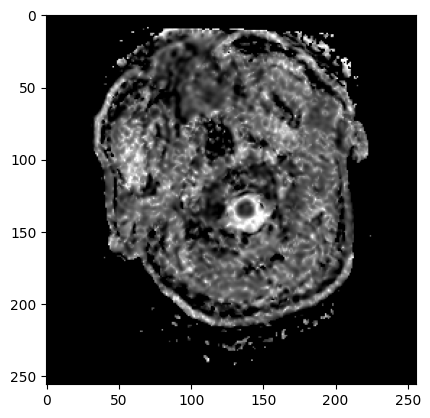

In [115]:
ds = pydicom.dcmread('I00001')
auxdicom = ds.pixel_array

print(np.min(auxdicom), np.max(auxdicom))
print(auxdicom.dtype)
print(auxdicom.shape)
plt.imshow(auxdicom, cmap="gray")
plt.show()

In [116]:
ds.save_as("temp.dcm")

0.0 1.0


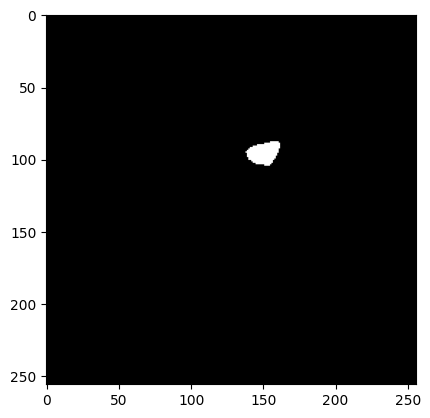

In [130]:
testfile = "/data/Datasets/stroke/clinical_validation/ACV-106/ACV-106_mask.nii"
nifti_file = nib.load(testfile).get_fdata()
print(np.min(nifti_file), np.max(nifti_file))
plt.imshow(nifti_file[...,14], cmap="gray")
plt.show()

In [132]:
nifti_file[...,14][95:105,125:175]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [128]:
ds = pydicom.dcmread('I00001')
ds.PixelData = nifti_file[...,14].astype('int16').tobytes()
#ds.PixelData = nifti_file[...,14].tobytes()
ds.save_as("nuevo")

In [ ]:
ds = pydicom.dcmread("nuevo")
plt.imshow(ds.PixelData)
plt.show()

In [7]:
masksizes = []

for fn in mylist:
    #print(fn, "......")
    #os.mkdir(os.path.join(mypath,fn,mypath_output))
    #temp_list = os.listdir(os.path.join(mypath,fn))
    #temp_list.sort()
    #print("\t", temp_list)
    nifti_file = nib.load(os.path.join(mypath,fn,fn+"_mask.nii")).get_fdata()
    #print("\""+fn+"\","+str(np.sum(nifti_file)))
    print(fn, int(np.sum(nifti_file)))
    #print("\t", nifti_file.shape)
    #temp_list = next(os.walk(os.path.join(mypath,fn)))[2]
    masksizes.append([fn, int(np.sum(nifti_file))])

ACV-106 4356
ACV-127 276
ACV-130 932
ACV-174 2657
ACV-192 1334
ACV-224 12995
ACV-225 53
ACV-226 6095
ACV-229 3129
ACV-231 338
ACV-233 148
ACV-234 322
ACV-237 4972
ACV-238 172
ACV-240 1106
ACV-241 265
ACV-242 179
ACV-244 844
ACV-245 1929
ACV-246 20633
ACV-247 469
ACV-248 1110
ACV-249 255
ACV-251 830
ACV-252 6567
ACV-253 203
ACV-254 219
ACV-256 470
ACV-259 315
ACV-260 10567
ACV-263 118
ACV-265 167
ACV-267 7236
ACV-268 12194
ACV-269 5569
ACV-273 1474
ACV-274 1373
ACV-275 2054
ACV-281 21590
ACV-285 2774
ACV-287 265
ACV-288 20257
ACV-289 3848
ACV-291 1532
ACV-294 232


In [11]:
np.array(masksizes)

array([['ACV-106', '4356'],
       ['ACV-127', '276'],
       ['ACV-130', '932'],
       ['ACV-174', '2657'],
       ['ACV-192', '1334'],
       ['ACV-224', '12995'],
       ['ACV-225', '53'],
       ['ACV-226', '6095'],
       ['ACV-229', '3129'],
       ['ACV-231', '338'],
       ['ACV-233', '148'],
       ['ACV-234', '322'],
       ['ACV-237', '4972'],
       ['ACV-238', '172'],
       ['ACV-240', '1106'],
       ['ACV-241', '265'],
       ['ACV-242', '179'],
       ['ACV-244', '844'],
       ['ACV-245', '1929'],
       ['ACV-246', '20633'],
       ['ACV-247', '469'],
       ['ACV-248', '1110'],
       ['ACV-249', '255'],
       ['ACV-251', '830'],
       ['ACV-252', '6567'],
       ['ACV-253', '203'],
       ['ACV-254', '219'],
       ['ACV-256', '470'],
       ['ACV-259', '315'],
       ['ACV-260', '10567'],
       ['ACV-263', '118'],
       ['ACV-265', '167'],
       ['ACV-267', '7236'],
       ['ACV-268', '12194'],
       ['ACV-269', '5569'],
       ['ACV-273', '1474'],
       [

In [13]:
DF = pd.DataFrame(np.array(masksizes))
DF.to_csv("data1.csv", index=False, header=False)

# Creating filenames according to standard

In [2]:
import os
import shutil
import glob

In [3]:
mypathfix = "/data/Datasets/stroke/clinical_validation/"
new_ones = ["ACV-008","ACV-013","ACV-016","ACV-017","ACV-058","ACV-069","ACV-119","ACV-136","ACV-223","ACV-230","ACV-262","ACV-264","ACV-270","ACV-295","ACV-296","ACV-297","ACV-300","ACV-302","ACV-303","ACV-304","ACV-305","ACV-308","ACV-310","ACV-311","ACV-313","ACV-315","ACV-317","ACV-323","ACV-324","ACV-329","ACV-330","ACV-331","ACV-332","ACV-339","ACV-342","ACV-343","ACV-344","ACV-349","ACV-352","ACV-354","ACV-357","ACV-364","ACV-365","ACV-366","ACV-367","ACV-369","ACV-370","ACV-371","ACV-372","ACV-377","ACV-378","ACV-379","ACV-380","ACV-381","ACV-382","ACV-384","ACV-385","ACV-387"]
numfolders = len(new_ones)

In [ ]:
for p in range(numfolders):
    print(os.path.join(mypathfix, new_ones[p]))
    #os.chdir(os.path.join(mypathfix, new_ones[p]))
    files = next(os.walk(os.path.join(mypathfix, new_ones[p])))[1]
    for fn in files:
        if "ADC" in fn:
            src = glob.glob(os.path.join(mypathfix, new_ones[p], fn, "*.nii.gz"))[0]
            dst = os.path.join(mypathfix, new_ones[p], new_ones[p]+"_ADC.nii.gz")
            shutil.copyfile(src, dst)
        
        if "NCCT" in fn:
            src = glob.glob(os.path.join(mypathfix, new_ones[p], fn, "*.nii.gz"))[0]
            dst = os.path.join(mypathfix, new_ones[p], new_ones[p]+"_NCCT.nii.gz")
            shutil.copyfile(src, dst)
        
        if "Mask" in fn:
            src = glob.glob(os.path.join(mypathfix, new_ones[p], fn, "*.nii"))[0]
            dst = os.path.join(mypathfix, new_ones[p], new_ones[p]+"_mask.nii")
            shutil.copyfile(src, dst)
    #break

In [4]:
import itertools
import numpy as np

r = os.listdir(mypathfix)
r.sort()

idx = np.random.permutation(len(r))

random_list = []
for i in idx:
    random_list.append(r[i])

In [ ]:
random_list

In [6]:
["ACV-234","ACV-268","ACV-288","ACV-225","ACV-380","ACV-136","ACV-289","ACV-354","ACV-167","ACV-369","ACV-265","ACV-275","ACV-172","ACV-267","ACV-366","ACV-379","ACV-237","ACV-224","ACV-262","ACV-253","ACV-385","ACV-127","ACV-273","ACV-247","ACV-296","ACV-270","ACV-173","ACV-310","ACV-331","ACV-365","ACV-324","ACV-291","ACV-303","ACV-226","ACV-008","ACV-246","ACV-251","ACV-130","ACV-151","ACV-150","ACV-323","ACV-256","ACV-192","ACV-287","ACV-159","ACV-238","ACV-344","ACV-343","ACV-249","ACV-352","ACV-229","ACV-241","ACV-223","ACV-155","ACV-252","ACV-263","ACV-302","ACV-317","ACV-367","ACV-274","ACV-119","ACV-244","ACV-260","ACV-281","ACV-364","ACV-233","ACV-166","ACV-297","ACV-332","ACV-311","ACV-149","ACV-294","ACV-230","ACV-162","ACV-329","ACV-342","ACV-245","ACV-163","ACV-017","ACV-259","ACV-016","ACV-269","ACV-240","ACV-339","ACV-300","ACV-231","ACV-106","ACV-315","ACV-308","ACV-242","ACV-254","ACV-285","ACV-069","ACV-145","ACV-295","ACV-357","ACV-313","ACV-248","ACV-013","ACV-174"]

['ACV-234',
 'ACV-268',
 'ACV-288',
 'ACV-225',
 'ACV-380',
 'ACV-136',
 'ACV-289',
 'ACV-354',
 'ACV-167',
 'ACV-369',
 'ACV-265',
 'ACV-275',
 'ACV-172',
 'ACV-267',
 'ACV-366',
 'ACV-379',
 'ACV-237',
 'ACV-224',
 'ACV-262',
 'ACV-253',
 'ACV-385',
 'ACV-127',
 'ACV-273',
 'ACV-247',
 'ACV-296',
 'ACV-270',
 'ACV-173',
 'ACV-310',
 'ACV-331',
 'ACV-365',
 'ACV-324',
 'ACV-291',
 'ACV-303',
 'ACV-226',
 'ACV-008',
 'ACV-246',
 'ACV-251',
 'ACV-130',
 'ACV-151',
 'ACV-150',
 'ACV-323',
 'ACV-256',
 'ACV-192',
 'ACV-287',
 'ACV-159',
 'ACV-238',
 'ACV-344',
 'ACV-343',
 'ACV-249',
 'ACV-352',
 'ACV-229',
 'ACV-241',
 'ACV-223',
 'ACV-155',
 'ACV-252',
 'ACV-263',
 'ACV-302',
 'ACV-317',
 'ACV-367',
 'ACV-274',
 'ACV-119',
 'ACV-244',
 'ACV-260',
 'ACV-281',
 'ACV-364',
 'ACV-233',
 'ACV-166',
 'ACV-297',
 'ACV-332',
 'ACV-311',
 'ACV-149',
 'ACV-294',
 'ACV-230',
 'ACV-162',
 'ACV-329',
 'ACV-342',
 'ACV-245',
 'ACV-163',
 'ACV-017',
 'ACV-259',
 'ACV-016',
 'ACV-269',
 'ACV-240',
 'AC

# Delete redundant files